# Validação cruzada

A validação cruzada é uma técnica de machine learning usada para avaliar a capacidade de generalização de um modelo, ou seja, sua performance em dados não vistos durante o treinamento. Ela ajuda a evitar problemas como o overfitting (quando o modelo se ajusta demais aos dados de treinamento) e fornece uma estimativa mais robusta do desempenho do modelo em cenários reais.

A validação cruzada consiste em dividir o conjunto de dados original em várias partes (ou dobras) e treinar o modelo múltiplas vezes, cada vez utilizando uma parte diferente dos dados para teste e as partes restantes para treinamento. O objetivo é garantir que cada observação no conjunto de dados seja usada tanto para treinamento quanto para teste, proporcionando uma avaliação mais confiável do modelo.

### Passos Básicos na Validação Cruzada

1. **Divisão dos Dados**:
   - O conjunto de dados é dividido em $k$ partes ou dobras (folds). O número $k$ é escolhido pelo usuário, sendo valores comuns $k = 5$ ou $k = 10$.
   
2. **Treinamento e Teste**:
   - Para cada iteração da validação cruzada:
     1. Uma das $k$ partes é separada como conjunto de teste.
     2. As outras $k-1$ partes são combinadas para formar o conjunto de treinamento.
     3. O modelo é treinado usando o conjunto de treinamento e, em seguida, avaliado no conjunto de teste.
     
3. **Cálculo da Métrica de Desempenho**:
   - A métrica de desempenho (como acurácia, erro quadrático médio, ou $R^2$) é calculada para cada iteração.
   - Após completar as $k$ iterações, as métricas de desempenho são agregadas (geralmente tomando a média) para fornecer uma estimativa final do desempenho do modelo.

### Importância da Validação Cruzada

- **Estimativa de Generalização**: A validação cruzada oferece uma estimativa de como o modelo se comportará em novos dados, ajudando a escolher o modelo que generaliza melhor.
  
- **Redução de Variância**: Como cada observação no conjunto de dados é usada tanto para treinamento quanto para teste, a validação cruzada reduz a variância nas estimativas de desempenho, fornecendo uma métrica mais estável.

- **Comparação de Modelos**: Permite a comparação justa entre diferentes modelos ou configurações de modelos, pois todos são avaliados usando exatamente os mesmos dados.

### Limitações da Validação Cruzada

- **Custo Computacional**: Pode ser computacionalmente caro, especialmente para modelos complexos ou grandes conjuntos de dados, pois envolve múltiplas execuções do processo de treinamento e teste.

- **Viés em Pequenos Conjuntos de Dados**: Em conjuntos de dados muito pequenos, mesmo a validação cruzada pode não fornecer uma estimativa confiável devido à alta variabilidade.


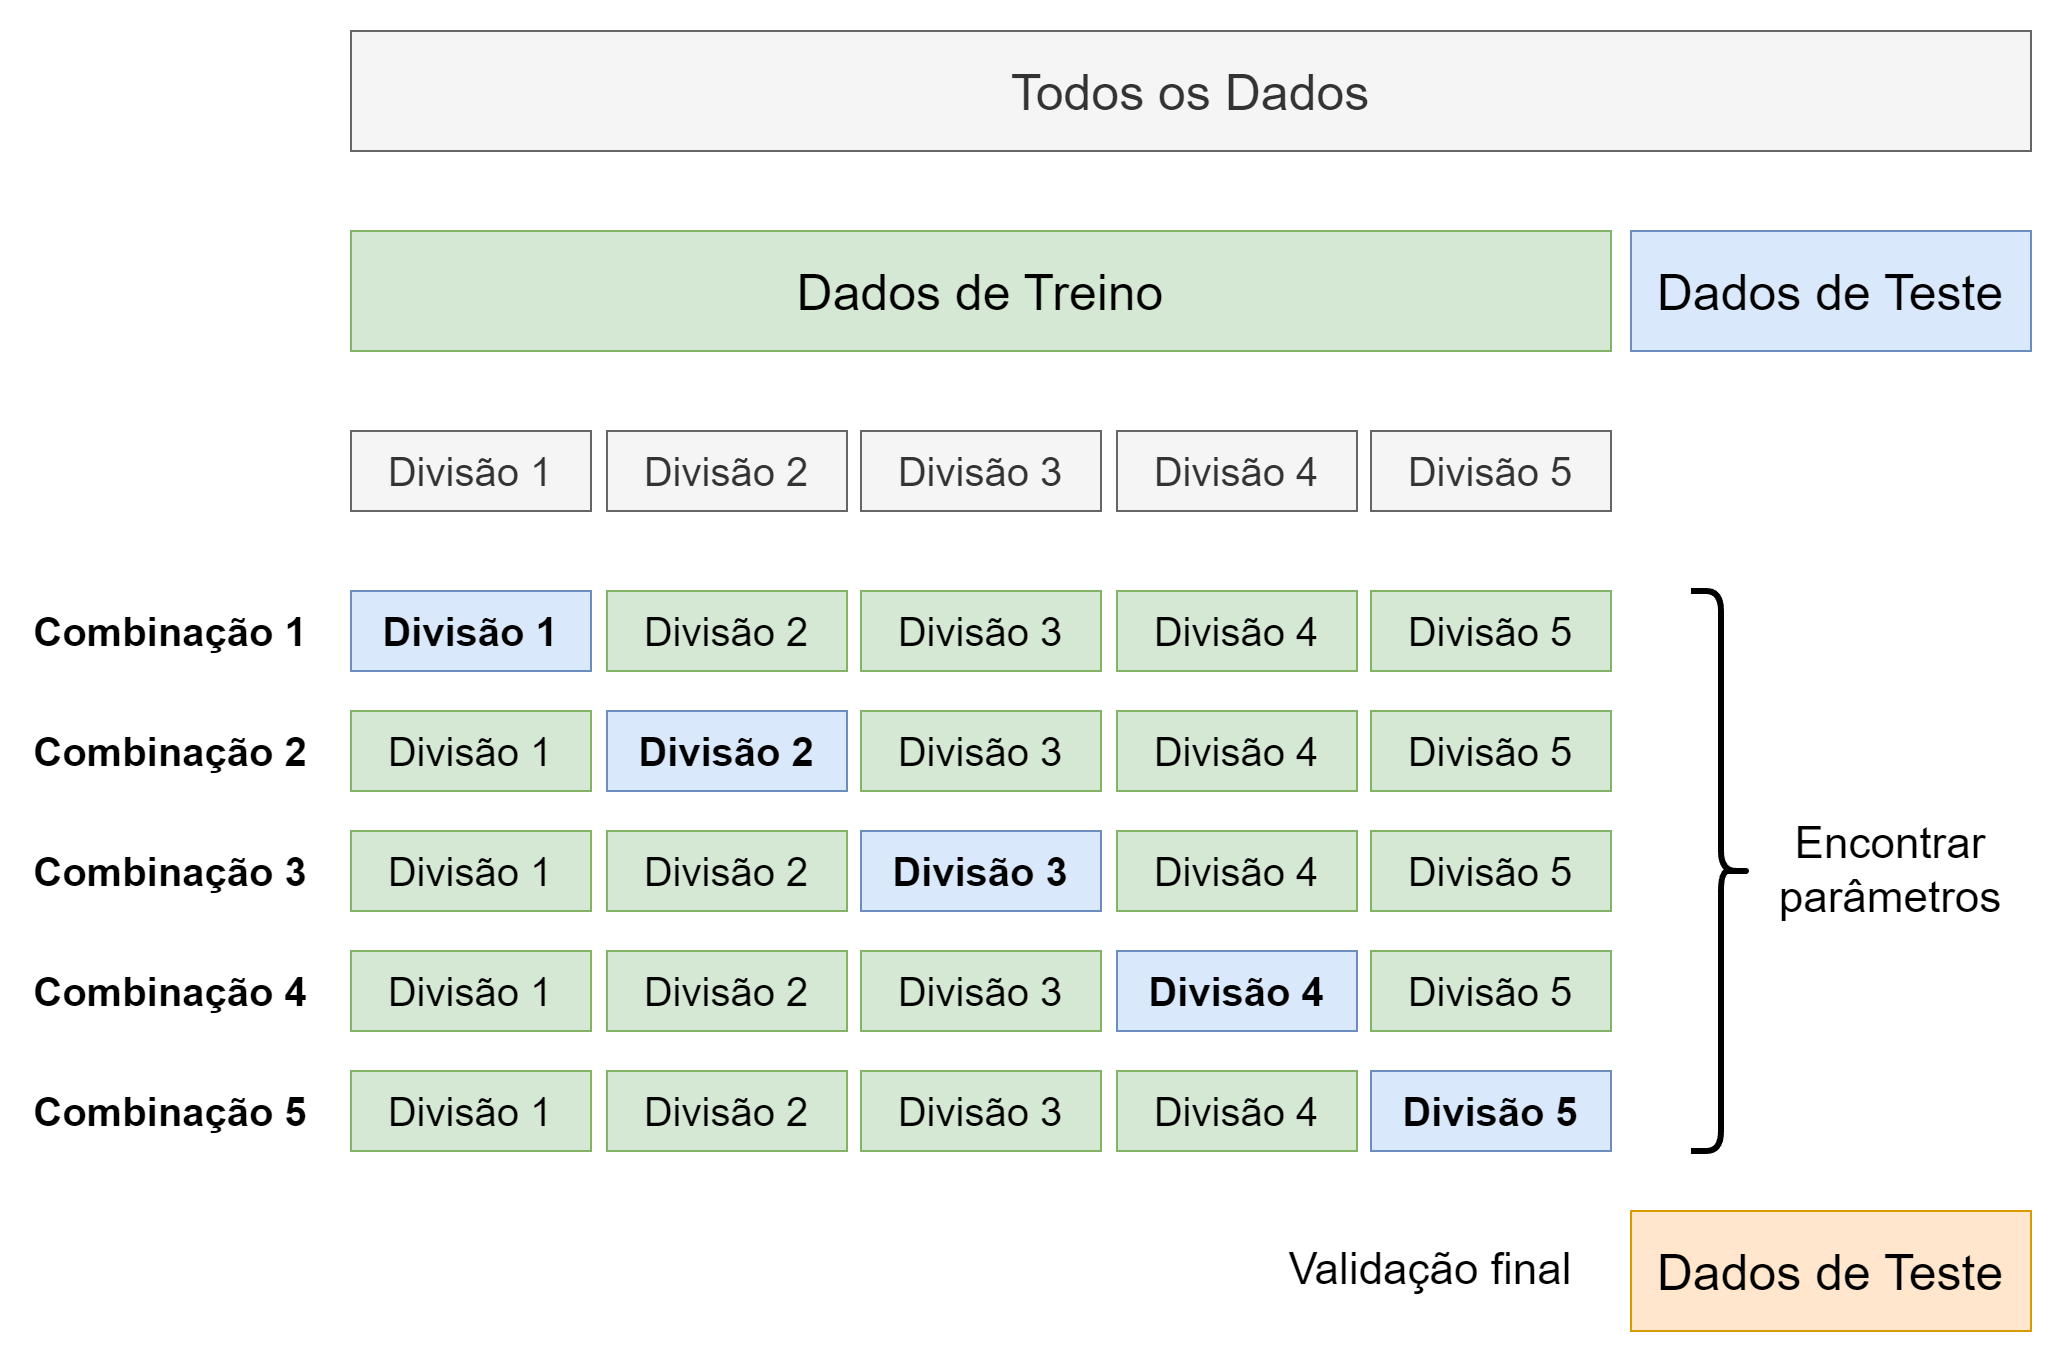

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
)

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_CATEGORIZADOS
from src.graficos import plot_coeficientes, plot_residuos

sns.set_theme(palette="bright")

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [4]:
colunas_power_transform = ["imc", "ldl", "hdl", "colesterol_total"]

coluna_target = ["target"]

coluna_ordinal_encoder = ["colesterol_hdl_cat"]

coluna_one_hot_encoder = ["sexo"]

colunas_standard_scaler = [
    coluna
    for coluna in df.columns
    if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [5]:
categorias_ordinal_encoder = [
    ["2-3", "4-5", "6+"],
]

In [6]:
X = df.drop(columns="target")
y = df["target"]

In [7]:
preprocessamento = ColumnTransformer(
    [
        ("power_transform", PowerTransformer(method="box-cox"), colunas_power_transform),
        ("standard_scaler", StandardScaler(), colunas_standard_scaler),
        ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), coluna_one_hot_encoder),
    ]
)

In [8]:
pipeline = Pipeline([
    ("preprocessor", preprocessamento),
    ("reg", LinearRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [9]:
regressor = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=QuantileTransformer(n_quantiles=20, output_distribution="normal"),
)

regressor

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('power_transform',
                                                                                       PowerTransformer(method='box-cox'),
                                                                                       ['imc',
                                                                                        'ldl',
                                                                                        'hdl',
                                                                                        'colesterol_total']),
                                                                                      ('standard_scaler',
                                                                                       StandardScaler(),
                                                                                       ['idade',
                                                                                        'pressao_media',
                                                                                        'triglicerides',
                                                                                        'glicose']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(categories=[['2-3',
                                                                                                                   '4-5',
                                                                                                                   '6+']]),
                                                                                       ['colesterol_hdl_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='if_binary'),
                                                                                       ['sexo'])])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(n_quantiles=20,
                                                           output_distribution='normal'))

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/model_evaluation.html

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scores = cross_validate(
    regressor,
    X,
    y,
    cv=kf,
    scoring=[
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
    ],
)

scores

{'fit_time': array([0.24284577, 0.17507291, 0.15716791, 0.21206999, 0.22715354]),
 'score_time': array([0.01573348, 0.01185775, 0.01384354, 0.01840878, 0.01942563]),
 'test_r2': array([0.45108178, 0.57092306, 0.38388743, 0.57951614, 0.39805057]),
 'test_neg_mean_absolute_error': array([-42.03921056, -40.89708237, -47.25762578, -42.4955739 ,
        -46.10167318]),
 'test_neg_mean_squared_error': array([-2908.25205111, -2676.84349863, -3353.45670625, -2830.00579966,
        -3363.44095538]),
 'test_neg_root_mean_squared_error': array([-53.92821201, -51.73822087, -57.90903821, -53.19779882,
        -57.99518045])}

In [11]:
scores_df = pd.DataFrame(scores)

scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.242846,0.015733,0.451082,-42.039211,-2908.252051,-53.928212
1,0.175073,0.011858,0.570923,-40.897082,-2676.843499,-51.738221
2,0.157168,0.013844,0.383887,-47.257626,-3353.456706,-57.909038
3,0.212070,0.018409,0.579516,-42.495574,-2830.005800,-53.197799
4,0.227154,0.019426,0.398051,-46.101673,-3363.440955,-57.995180


In [12]:
scores_df.describe()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.202862,0.015854,0.476692,-43.758233,-3026.399802,-54.953690
std,0.035825,0.003135,0.093415,2.760117,314.357306,2.848629
min,0.157168,0.011858,0.383887,-47.257626,-3363.440955,-57.995180
25%,0.175073,0.013844,0.398051,-46.101673,-3353.456706,-57.909038
50%,0.212070,0.015733,0.451082,-42.495574,-2908.252051,-53.928212
75%,0.227154,0.018409,0.570923,-42.039211,-2830.005800,-53.197799
max,0.242846,0.019426,0.579516,-40.897082,-2676.843499,-51.738221


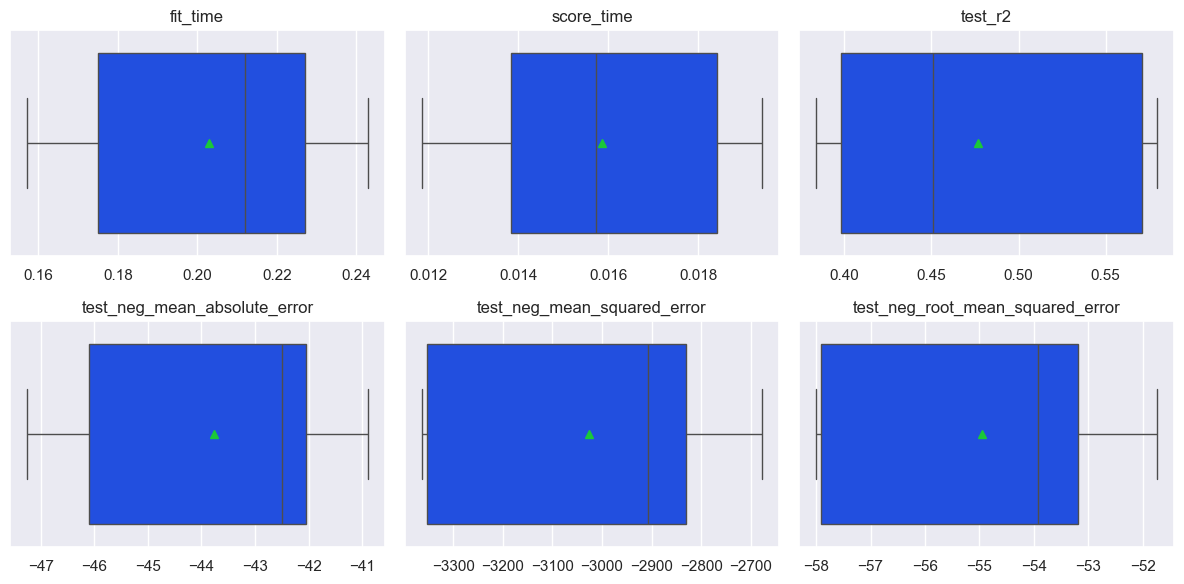

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, score in zip(axs.flatten(), scores.keys()):
    sns.boxplot(
        x=scores[score],
        ax=ax,
        showmeans=True,
    )
    ax.set_title(score)

plt.tight_layout()
plt.show()